In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D

from scipy.interpolate import griddata
import time

np.random.seed(1234)

As a proof of concept of divide and conquer phyiscs informed neural networks, we consider the ODE

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}(t) = \begin{pmatrix} -y_2 \\ y_1 \end{pmatrix} (t).
\end{align*}

For a given initial state $y_0 = (y_0^1, y_0^2) \in \mathbb{R}^2$, the solution $(y(t))_{t\geq0}$ flows in counter clockwise circles and is given by

\begin{align*}
    y(t) = \begin{pmatrix} y_0^1 \cos(t) - y_0^2 \sin(t) \\ y_0^2 \cos(t) + y_0^1 \sin(t) \end{pmatrix}.
\end{align*}

In [2]:
def vector_field(y):
    
    return torch.tensor([-y[1], y[0]])


def solution_simple_ODE(t, y0):
    
    y1t = y0[0] * np.cos(t) - y0[1] * np.sin(t)
    y2t = y0[1] * np.cos(t) + y0[0] * np.sin(t)

    return np.array([y1t, y2t])

In [3]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [5]:
# PINN: physics-informed neural network
class PINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, layers, T):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for i in range(2)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # This is specific to the ODE
        loss_pinn1 = torch.mean((deriv_pred[0] + y_pred[:,1:2]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[1] - y_pred[:,0:1]) ** 2)
        loss_pinn = loss_pinn1 + loss_pinn2
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss = loss_pinn + loss_smooth + loss_semigroup
        
        loss.backward()
        self.iter += 1
        
        if self.iter % 100 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    
    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

### Setup data example

In [6]:
layers = [3, 20, 20, 20, 20, 2]

T = 1
max_y0 = 5

# standard PINN loss function training samples
N_pinn = 10000
N_semigroup = 10000
N_smooth = 10000


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = np.random.uniform(0, max_y0, (N_pinn, 2))
X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = np.random.uniform(0, max_y0, (N_semigroup, 2))
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = np.random.uniform(0, max_y0, (N_smooth, 2))
X_smooth = np.hstack([t_smooth, y_smooth])

In [7]:
model = PINN(X_pinn, X_semigroup, X_smooth, layers, T)

In [8]:
%%time
               
model.train()

Iter 100, Loss: 0.02960, Loss_pinn: 0.02153 Loss_smooth: 0.00778, Loss_semigroup: 0.00029
Iter 200, Loss: 0.00383, Loss_pinn: 0.00219 Loss_smooth: 0.00154, Loss_semigroup: 0.00009
Iter 300, Loss: 0.00140, Loss_pinn: 0.00065 Loss_smooth: 0.00072, Loss_semigroup: 0.00004
Iter 400, Loss: 0.00053, Loss_pinn: 0.00027 Loss_smooth: 0.00025, Loss_semigroup: 0.00001
Iter 500, Loss: 0.00029, Loss_pinn: 0.00013 Loss_smooth: 0.00016, Loss_semigroup: 0.00001
Iter 600, Loss: 0.00015, Loss_pinn: 0.00007 Loss_smooth: 0.00007, Loss_semigroup: 0.00000
Iter 700, Loss: 0.00011, Loss_pinn: 0.00005 Loss_smooth: 0.00005, Loss_semigroup: 0.00000
Iter 800, Loss: 0.00007, Loss_pinn: 0.00004 Loss_smooth: 0.00004, Loss_semigroup: 0.00000
Iter 900, Loss: 0.00005, Loss_pinn: 0.00002 Loss_smooth: 0.00003, Loss_semigroup: 0.00000
Iter 1000, Loss: 0.00004, Loss_pinn: 0.00002 Loss_smooth: 0.00002, Loss_semigroup: 0.00000
Iter 1100, Loss: 0.00003, Loss_pinn: 0.00001 Loss_smooth: 0.00002, Loss_semigroup: 0.00000
Iter 120

## Predict and Plot the Solution

In [9]:
def generate_figure(figsize, xlim, ylim):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return fig, ax


def plot_ode_solution(ax, y, *args, **kwargs):
    
    ax.plot(y[:,0], y[:,1], '.-', *args, **kwargs)
    
    return ax

In [10]:
def predict_standard(model, y0, max_t_pred, delta_t):
    
    times = np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    times = times[:,np.newaxis]
    
    y0 = np.array([y0 for _ in range(len(times))])
    trajectory =  model.predict(times, y0)
    
    return trajectory


def predict_dac(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [11]:
# Note that max_t in training is 1
y0 = [4., 0.]
max_t_pred = 7.
delta_t = 0.05

validation_dac = predict_dac(model, y0, max_t_pred, delta_t)
validation_standard = predict_standard(model, y0, max_t_pred, delta_t)

In [12]:
true_solution = np.array([
    solution_simple_ODE(t, y0) 
    for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
])

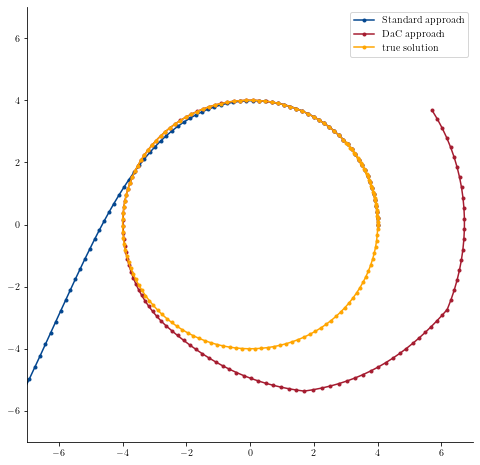

In [13]:
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_standard, label="Standard approach", color="#03468F")
ax = plot_ode_solution(ax, validation_dac, label="DaC approach", color="#A51C30")
ax = plot_ode_solution(ax, true_solution, label="true solution", color="orange")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

## Evaluation and Ablation Studies

In [14]:
from decimal import Decimal

In [15]:
# layers = [3, 20, 20, 20, 20, 2]
# T = 1
# max_y0 = 5
# N_pinn = 10000
# N_semigroup = 10000
# N_smooth = 10000

N_evaluate = 1000

y0s = np.random.uniform(0, max_y0, (N_evaluate,2))

max_t_pred = 5.
delta_t = 0.01
distances = []


for y0 in y0s:
    
    dac_solution = predict_standard(model, y0, max_t_pred, delta_t)
    true_solution = np.array([
        solution_simple_ODE(t, y0) 
        for t in np.linspace(0, max_t_pred, int(max_t_pred / delta_t) + 1)
    ])
    distances.append(np.sqrt(np.sum((dac_solution - true_solution) ** 2, axis=1)))

In [16]:
print(f"Mean Euclidean distance: {Decimal(np.mean(distances)):.3E}, Std: {Decimal(np.std(distances)):.3E}")

Mean Euclidean distance: 3.692E+0, Std: 5.244E+0
